In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import griddata

import einops
import concurrent.futures
import pickle


import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import niapy
from niapy.problems import HappyCat as TestFunction

import hiposa
import hiposa.poisson_tiler

import os

In [2]:
def compute_masked_similarity(heatmap1, heatmap2, percentile=5, method='f1'):
    """
    Compute similarity metrics between two heatmaps after masking values below a specified percentile.
    
    Parameters:
    -----------
    heatmap1 : 2D numpy array
        First heatmap data, may contain NaNs
    heatmap2 : 2D numpy array
        Second heatmap data, may contain NaNs
    percentile : float, optional
        The percentile threshold to create masks (default: 5)
        Values below this percentile will be masked out
    method : str, optional
        Similarity method: 'f1', 'correlation', 'jaccard', or 'all' (default: 'f1')
        
    Returns:
    --------
    dict : A dictionary containing:
        - 'f1_score': F1 score between the masks (if method is 'f1' or 'all')
        - 'precision': Precision between the masks (if method is 'f1' or 'all')
        - 'recall': Recall between the masks (if method is 'f1' or 'all')
        - 'correlation': Correlation coefficient between masks (if method is 'correlation' or 'all')
        - 'p_value': P-value of the correlation (if method is 'correlation' or 'all')
        - 'jaccard': Jaccard similarity index (if method is 'jaccard' or 'all')
        - 'overlap_count': Number of overlapping non-NaN points after masking
        - 'mask1': Boolean mask for heatmap1 (True for values above threshold)
        - 'mask2': Boolean mask for heatmap2 (True for values above threshold)
        - 'threshold1': The percentile threshold value for heatmap1
        - 'threshold2': The percentile threshold value for heatmap2
    """
    # Handle invalid inputs
    if heatmap1.shape != heatmap2.shape:
        raise ValueError("Heatmaps must have the same shape")
    
    if not (0 <= percentile <= 100):
        raise ValueError("Percentile must be between 0 and 100")
    
    # Compute percentile thresholds, ignoring NaNs
    threshold1 = np.nanpercentile(heatmap1, percentile)
    threshold2 = np.nanpercentile(heatmap2, percentile)
    
    # Create masks (True where values are above threshold)
    mask1 = heatmap1 > threshold1
    mask2 = heatmap2 > threshold2
    
    # Create a common mask where both heatmaps have valid (non-NaN) values
    valid_mask = ~np.isnan(heatmap1) & ~np.isnan(heatmap2)
    
    # Combine with the percentile masks
    combined_mask1 = mask1 & valid_mask
    combined_mask2 = mask2 & valid_mask
    
    # Extract the masked values from both heatmaps
    values1 = heatmap1[valid_mask]
    values2 = heatmap2[valid_mask]
    
    # Create boolean arrays for correlation analysis (using the common valid points)
    bool_array1 = mask1[valid_mask]
    bool_array2 = mask2[valid_mask]
    
    # Count the overlap points (where both masks are True)
    overlap_count = np.sum(bool_array1 & bool_array2)
    total_valid = np.sum(valid_mask)
    
    # Confusion matrix elements
    true_positive = np.sum(bool_array1 & bool_array2)
    false_positive = np.sum(~bool_array1 & bool_array2)
    false_negative = np.sum(bool_array1 & ~bool_array2)
    true_negative = np.sum(~bool_array1 & ~bool_array2)
    
    # Calculate standard F1 score metrics
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate class-specific metrics for macro F1
    # Class 1 (positive class)
    precision_pos = precision  # Already calculated above
    recall_pos = recall  # Already calculated above
    f1_pos = f1  # Already calculated above
    
    # Class 0 (negative class)
    precision_neg = true_negative / (true_negative + false_negative) if (true_negative + false_negative) > 0 else 0
    recall_neg = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0
    f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg) if (precision_neg + recall_neg) > 0 else 0
    
    # Macro F1 (unweighted average of class F1 scores)
    macro_f1 = (f1_pos + f1_neg) / 2
    
    # Macro precision and recall
    macro_precision = (precision_pos + precision_neg) / 2
    macro_recall = (recall_pos + recall_neg) / 2
    
    # Micro F1 (calculated from summed confusion matrix)
    micro_precision = (true_positive + true_negative) / (true_positive + false_positive + true_negative + false_negative) if (true_positive + false_positive + true_negative + false_negative) > 0 else 0
    micro_recall = (true_positive + true_negative) / (true_positive + false_negative + true_negative + false_positive) if (true_positive + false_negative + true_negative + false_positive) > 0 else 0
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0
    
    # Balanced accuracy (average of recall for each class)
    balanced_accuracy = (recall_pos + recall_neg) / 2
    
    # Matthews correlation coefficient (robust to imbalance)
    mcc_numerator = true_positive * true_negative - false_positive * false_negative
    mcc_denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * 
                             (true_negative + false_positive) * (true_negative + false_negative))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0
    
    # Calculate Jaccard similarity (intersection over union)
    jaccard = true_positive / (true_positive + false_positive + false_negative) if (true_positive + false_positive + false_negative) > 0 else 0
    
    # Calculate correlation
    corr, p_value = stats.pearsonr(bool_array1.astype(float), bool_array2.astype(float))
    
    # Prepare results dictionary
    results = {
        # Standard metrics
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        
        # Class-balanced metrics
        'macro_f1': macro_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'micro_f1': micro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'balanced_accuracy': balanced_accuracy,
        'matthews_correlation': mcc,
        
        # Other metrics
        'jaccard': jaccard,
        'correlation': corr,
        'p_value': p_value,
        
        # Confusion matrix data
        'confusion_matrix': {
            'true_positive': true_positive,
            'false_positive': false_positive,
            'false_negative': false_negative,
            'true_negative': true_negative,
            'class_balance': {
                'positive_ratio': (true_positive + false_negative) / total_valid if total_valid > 0 else 0,
                'negative_ratio': (true_negative + false_positive) / total_valid if total_valid > 0 else 0
            }
        },
        
        # Original data
        'overlap_count': overlap_count,
        'total_valid_points': total_valid,
        'overlap_percentage': 100 * overlap_count / total_valid if total_valid > 0 else 0,
        'mask1': mask1,
        'mask2': mask2,
        'threshold1': threshold1,
        'threshold2': threshold2
    }
    
    return results



In [3]:
lower=-5
upper=5
f = TestFunction(dimension=2, upper=upper, lower=lower)

In [4]:
Ngrid = 100j
grid_x, grid_y = np.mgrid[lower:upper:Ngrid,lower:upper:Ngrid,]
f_gt = np.zeros_like(grid_x)
for i in range(100):
    for j in range(100):
        f_gt[i,j]=f( np.array((grid_y[i,j], grid_x[i,j])).flatten() )
        

In [7]:
def generate_poisson_points(i, lower, upper, scales):
    # Each worker function gets its own seed based on the iteration
    np.random.seed(42 + i)  # Optional but ensures reproducibility with different seeds
    
    pTiler = hiposa.poisson_tiler.PoissonTiler(tile_size=scales[0]*1, spacings=scales)
    xy, levels = pTiler.get_points_in_region([[lower, upper], [lower, upper]])
    print(f"Worker {i}: Generated {len(xy)} points")
    return (xy, levels)

scales = (upper-lower)/10 / (np.sqrt(2)**np.arange(0,7,1))
n_sets = 50

# Parallel execution using ThreadPoolExecutor
xyls = []
with concurrent.futures.ThreadPoolExecutor(max_workers=min(n_sets, 32)) as executor:
    # Submit all tasks
    futures = [executor.submit(generate_poisson_points, i, lower, upper, scales) 
               for i in range(n_sets)]
    
    # Collect results as they complete
    for future in concurrent.futures.as_completed(futures):
        xyls.append(future.result())

# Print total points generated
total_points = sum(len(xy) for xy, _ in xyls)
print(f"Total points generated: {total_points}")


Initializing PoissonTiler:
Requested tile size: 1.0
Actual tile size: 2.0 (minimum required: 2.0)
Spacings: [1.         0.70710678 0.5        0.35355339 0.25       0.1767767
 0.125     ]
Dimensions: 2
Tile domain: [(0, 2.0), (0, 2.0)]

Generating base tile...

Generating level 0 with spacing 1.0

Initializing PoissonTiler:
Requested tile size: 1.0
Actual tile size: 2.0 (minimum required: 2.0)
Spacings: [1.         0.70710678 0.5        0.35355339 0.25       0.1767767
 0.125     ]
Dimensions: 2
Tile domain: [(0, 2.0), (0, 2.0)]

Generating base tile...

Generating level 0 with spacing 1.0
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475

Initializing PoissonTiler:
Requested tile size: 1.0
Actual tile size: 2.0 (minimum required: 2.0)
Spacings: [1.         0.70710678 0.5        0.35355339 0.25       0.1767767
 0.125     ]
Dimensions: 2
Tile domain: [(0, 2.0), (0, 2.0)]

Generating base tile...

Generating level 0 with spacing 1.0

Initializing PoissonTiler

Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 2 points

Generating level 1 with spacing 0.7071067811865475
Level 1: Generated 3 points

Generating level 2 with spacing 0.4999999999999999
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 2 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 0: Generated 1 points

Generating 

Level 3: Generated 11 points

Generating level 4 with spacing 0.24999999999999994
Level 3: Generated 11 points

Generating level 4 with spacing 0.24999999999999994
Level 3: Generated 12 points

Generating level 4 with spacing 0.24999999999999994
Level 3: Generated 12 points

Generating level 4 with spacing 0.24999999999999994
Level 3: Generated 13 points

Generating level 4 with spacing 0.24999999999999994
Level 3: Generated 13 points

Generating level 4 with spacing 0.24999999999999994
Level 3: Generated 13 points

Generating level 4 with spacing 0.24999999999999994
Level 3: Generated 15 points

Generating level 4 with spacing 0.24999999999999994
Level 3: Generated 14 points

Generating level 4 with spacing 0.24999999999999994
Level 4: Generated 11 points

Generating level 5 with spacing 0.1767766952966368
Level 4: Generated 15 points

Generating level 5 with spacing 0.1767766952966368
Level 4: Generated 16 points

Generating level 5 with spacing 0.1767766952966368
Level 4: Generated 

Level 3: Generated 11 points

Generating level 4 with spacing 0.24999999999999994
Level 6: Generated 77 points

Base tile complete with 158 total points
Worker 3: Generated 4000 points

Initializing PoissonTiler:
Requested tile size: 1.0
Actual tile size: 2.0 (minimum required: 2.0)
Spacings: [1.         0.70710678 0.5        0.35355339 0.25       0.1767767
 0.125     ]
Dimensions: 2
Tile domain: [(0, 2.0), (0, 2.0)]

Generating base tile...

Generating level 0 with spacing 1.0
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 1: Generated 3 points

Generating level 2 with spacing 0.4999999999999999
Level 2: Generated 6 points

Generating level 3 with spacing 0.3535533905932737
Worker 6: Generated 4000 points

Initializing PoissonTiler:
Requested tile size: 1.0
Actual tile size: 2.0 (minimum required: 2.0)
Spacings: [1.         0.70710678 0.5        0.35355339 0.25       0.1767767
 0.125     ]
Dimensions: 2
Tile domain: [(0, 2.0), (0, 2.0)]

Generati

Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 4: Generated 20 points

Generating level 5 with spacing 0.1767766952966368
Level 1: Generated 4 points

Generating level 2 with spacing 0.4999999999999999
Worker 9: Generated 4025 points

Initializing PoissonTiler:
Requested tile size: 1.0
Actual tile size: 2.0 (minimum required: 2.0)
Spacings: [1.         0.70710678 0.5        0.35355339 0.25       0.1767767
 0.125     ]
Dimensions: 2
Tile domain: [(0, 2.0), (0, 2.0)]

Generating base tile...

Generating level 0 with spacing 1.0
Level 0: Generated 1 points

Generating level 1 with spacing 0.7071067811865475
Level 2: Generated 4 points

Generating level 3 with spacing 0.3535533905932737
Level 3: Generated 11 points

Generating level 4 with spacing 0.24999999999999994
Level 1: Generated 4 points

Generating level 2 with spacing 0.4999999999999999
Level 4: Generated 19 points

Generating level 5 with spacing 0.1767766952966368
Level 2: Generated 5 point

Level 6: Generated 79 points

Base tile complete with 162 total points
Worker 42: Generated 4025 points
Worker 37: Generated 4050 points
Level 6: Generated 80 points

Base tile complete with 163 total points
Worker 46: Generated 4075 points
Level 6: Generated 86 points

Base tile complete with 167 total points
Worker 47: Generated 4175 points
Level 6: Generated 86 points

Base tile complete with 165 total points
Worker 49: Generated 4125 points
Total points generated: 201575


In [9]:
import pickle
pickle.dump(xyls, open("designs.pickle", "wb") )

Single Instance


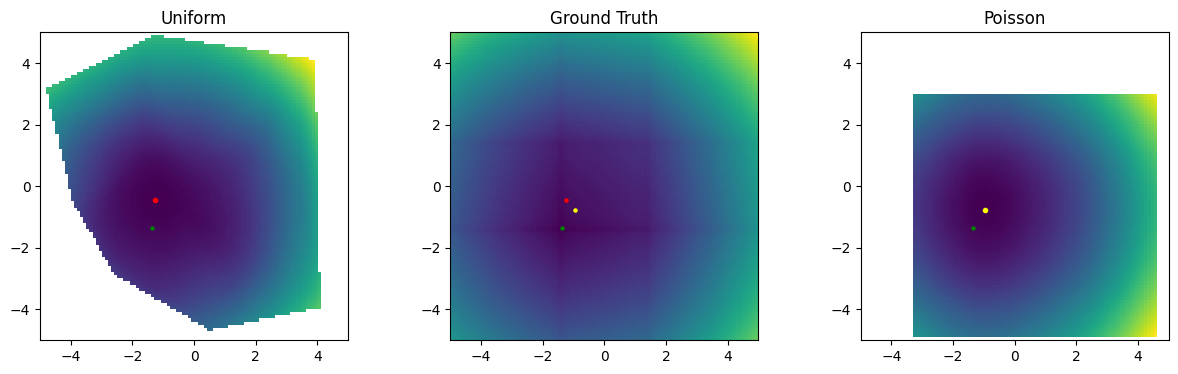

Single Instance Zoom


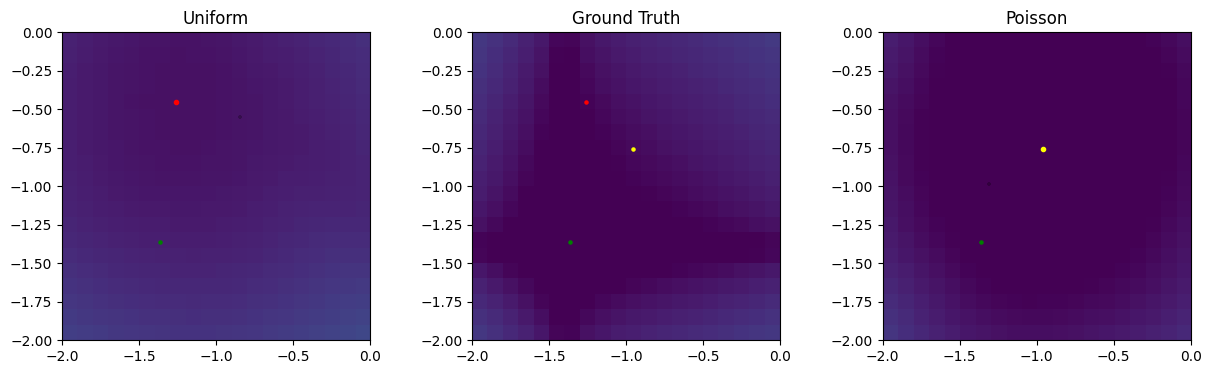

Agregate View


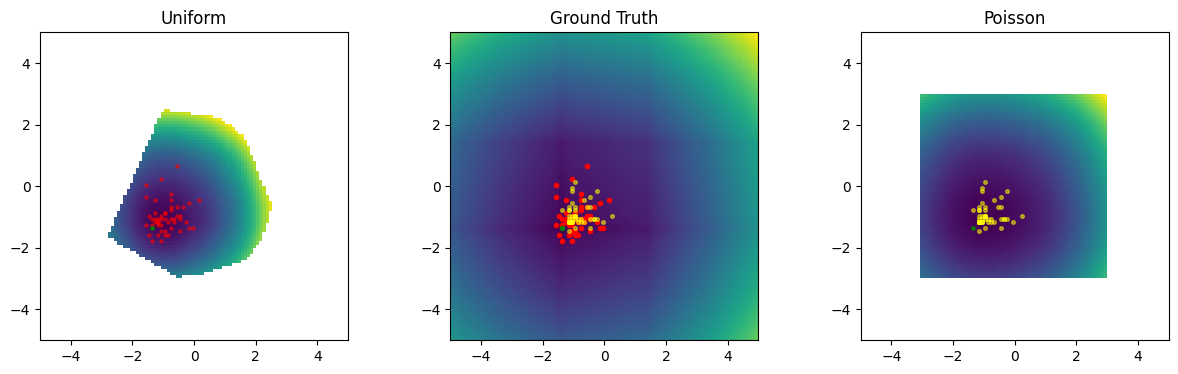

Disp U 0.626420416031962 0.7420132186959314 25.0
Disp H 0.5975228229719847 0.7142377879709874 25.0
F1 0.6580145528239325 0.6567323817277475 25.0

Single Instance


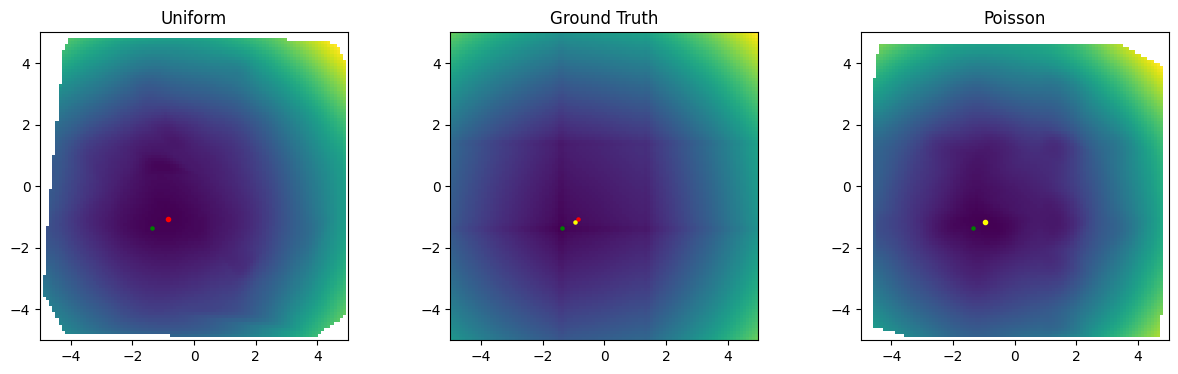

Single Instance Zoom


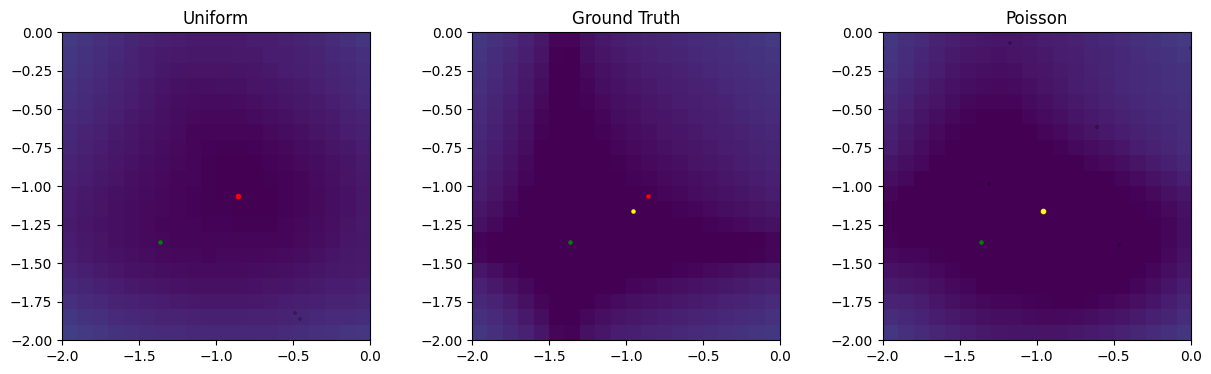

Agregate View


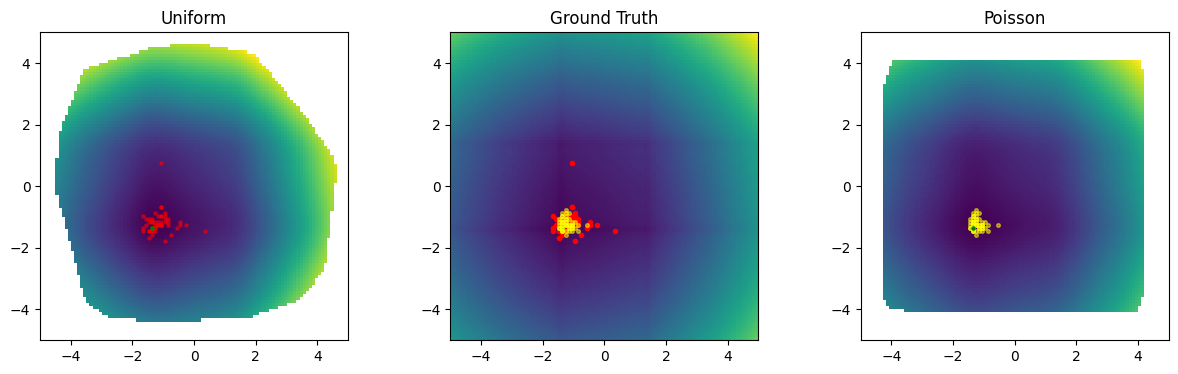

Disp U 0.3194219858755941 0.4522875847177667 125.0
Disp H 0.22586545227270607 0.2797839899668637 125.0
F1 0.8431483979047352 0.7959399737209399 125.0

Single Instance


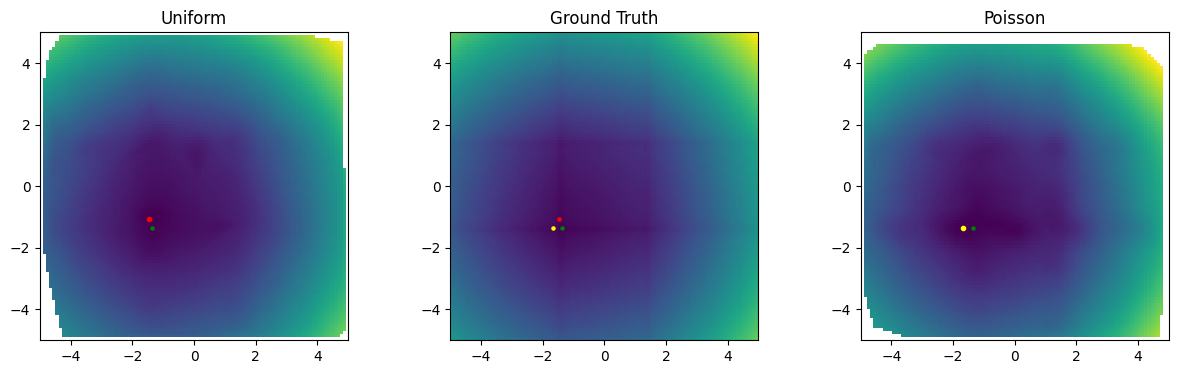

Single Instance Zoom


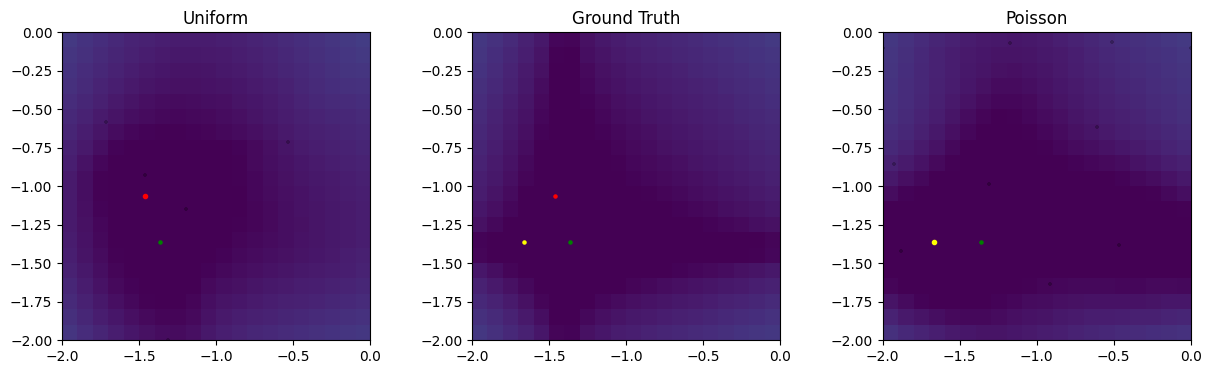

Agregate View


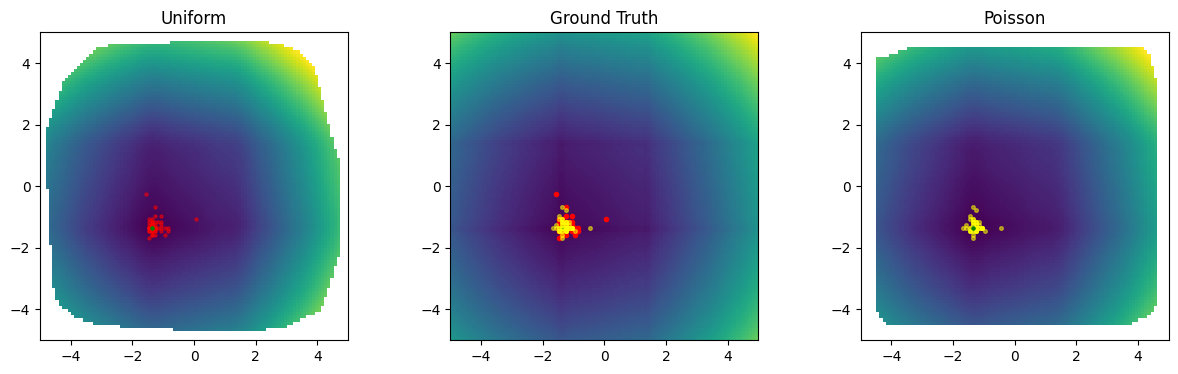

Disp U 0.1724350284026817 0.25765669536257063 250.0
Disp H 0.202020202020202 0.23076351619253518 250.0
F1 0.879358709995074 0.8498389953267934 250.0

Single Instance


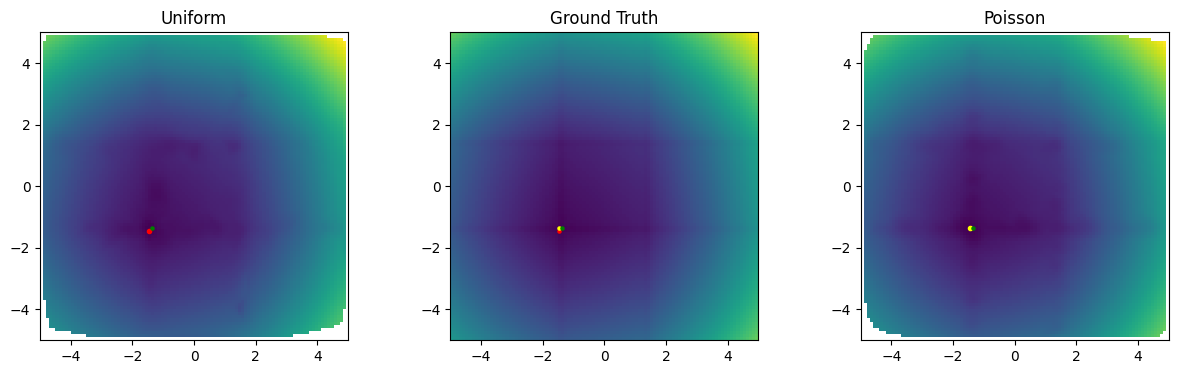

Single Instance Zoom


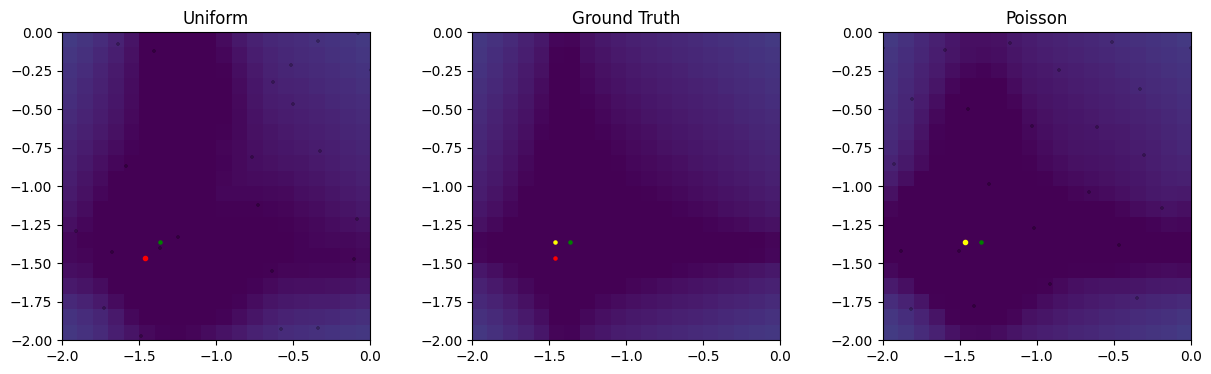

Agregate View


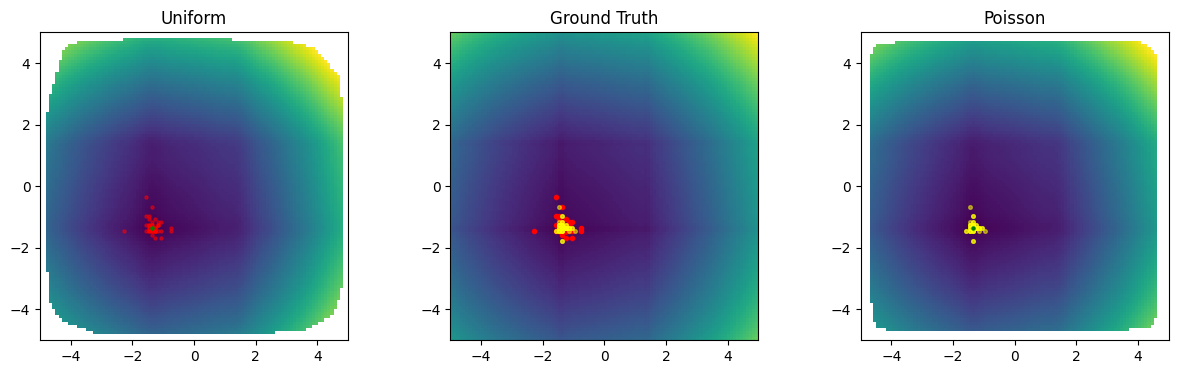

Disp U 0.1428498547851611 0.2307675051623115 525.0
Disp H 0.121929977897631 0.16657000777064057 525.0
F1 0.9083650589473646 0.8795728562918331 525.0

Single Instance


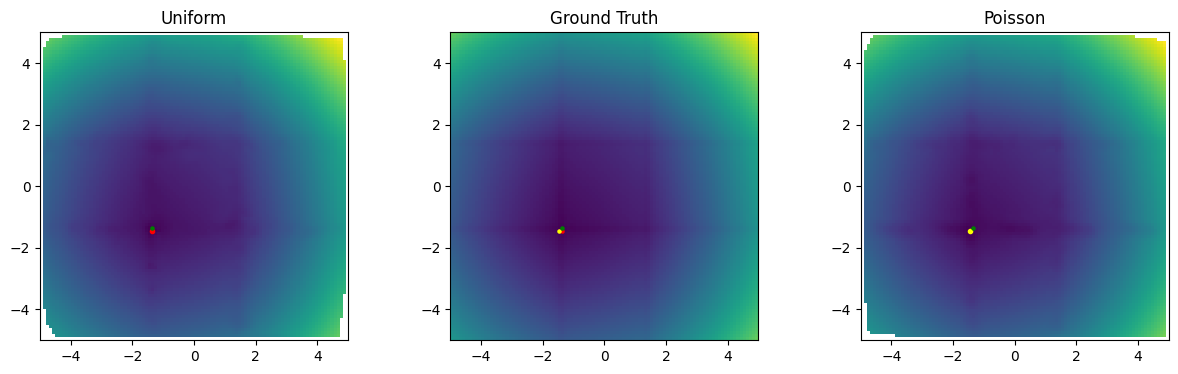

Single Instance Zoom


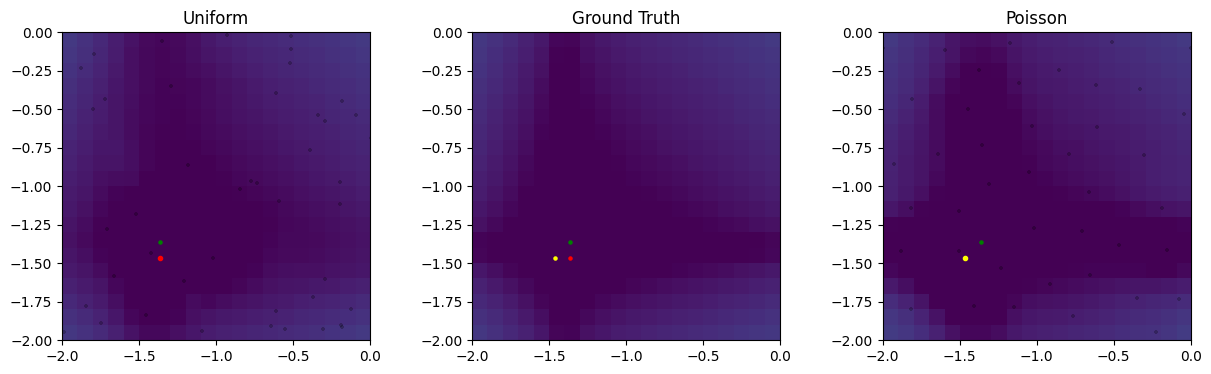

Agregate View


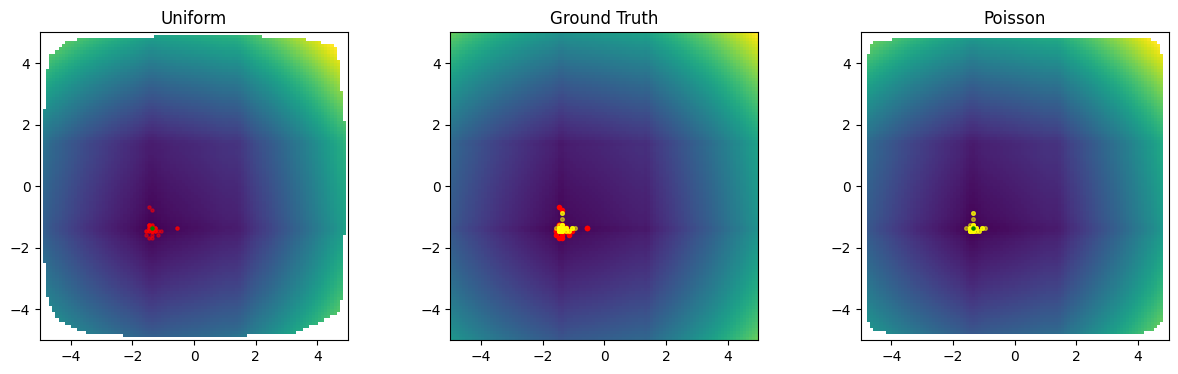

Disp U 0.10101010101010122 0.16664364318293295 1025.0
Disp H 0.10101010101010122 0.12886029182623093 1025.0
F1 0.9373976260215521 0.9221078335820743 1025.0

Single Instance


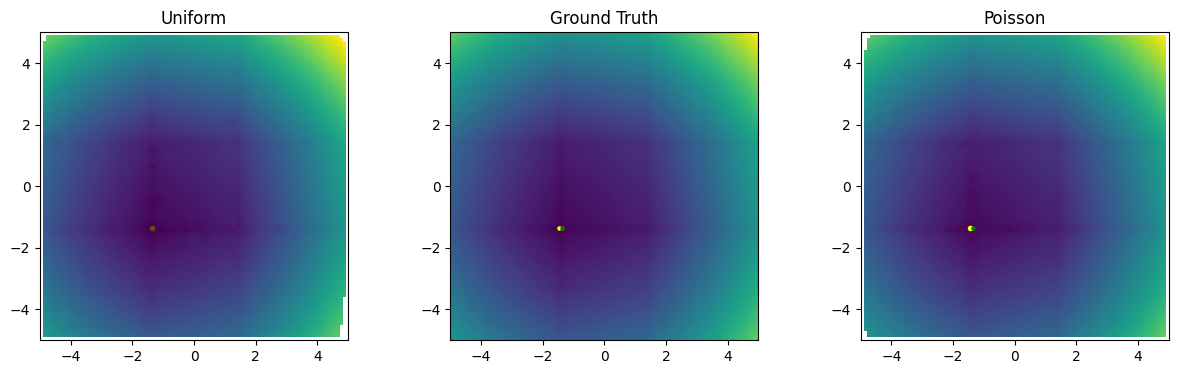

Single Instance Zoom


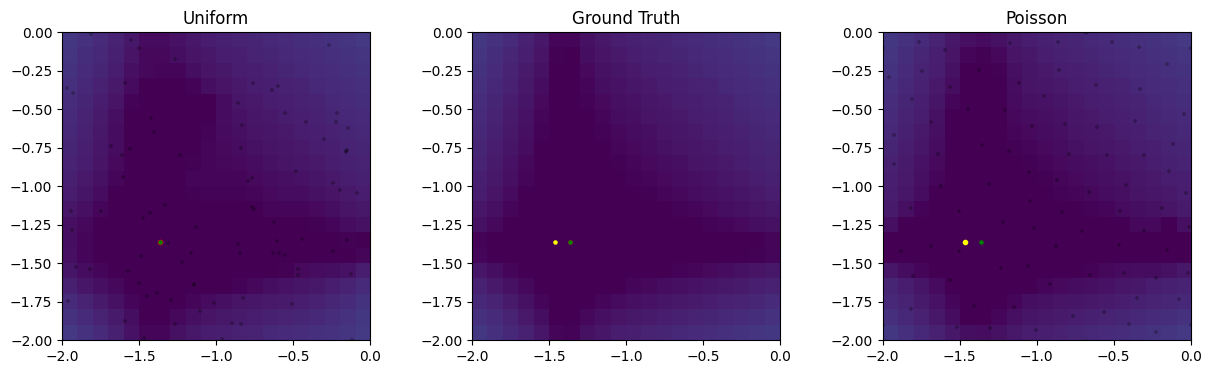

Agregate View


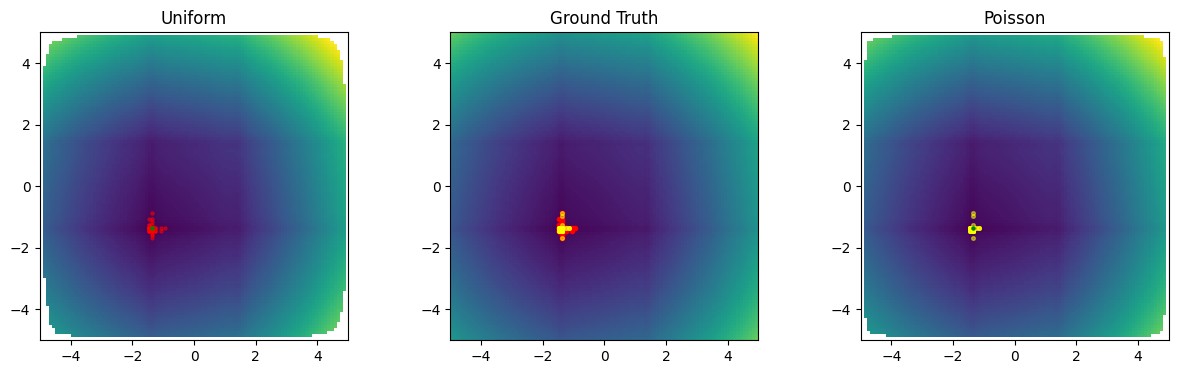

Disp U 0.10101010101010077 0.12821553726074278 2037.5
Disp H 0.10101010101010077 0.09627647323129761 2037.5
F1 0.9555664853104561 0.9416159932555569 2037.5

Single Instance


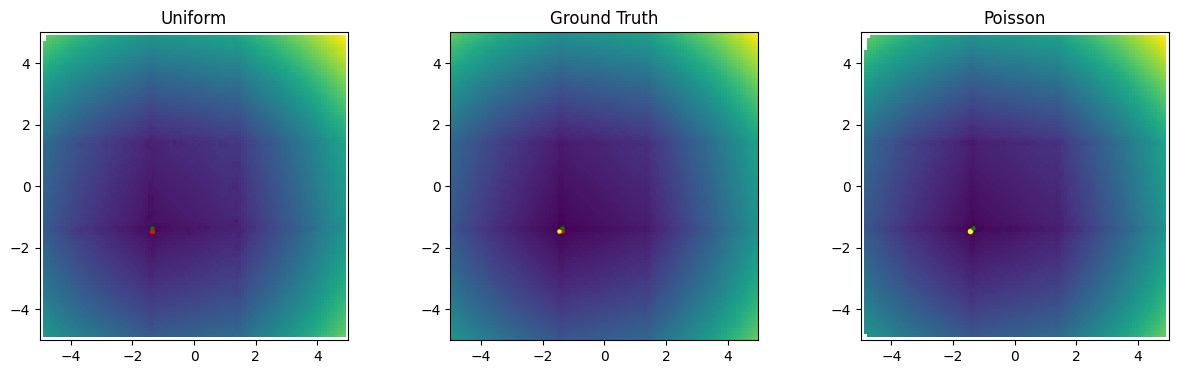

Single Instance Zoom


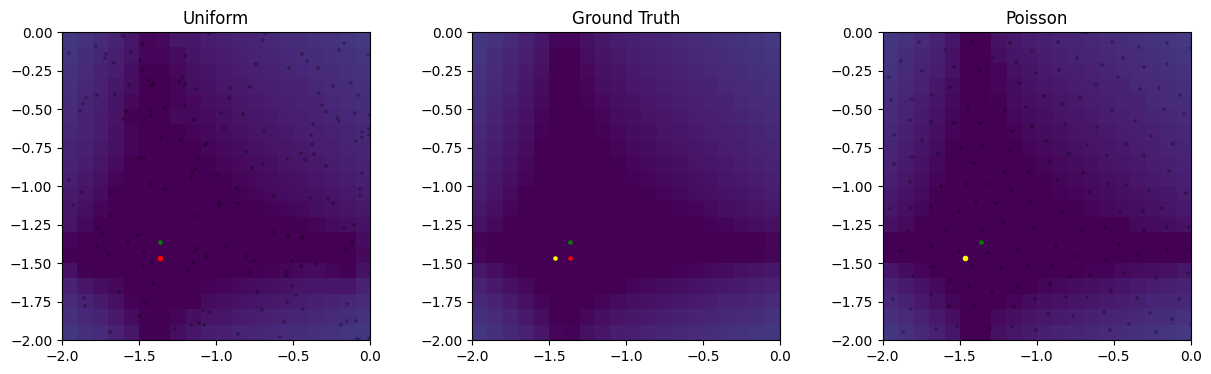

Agregate View


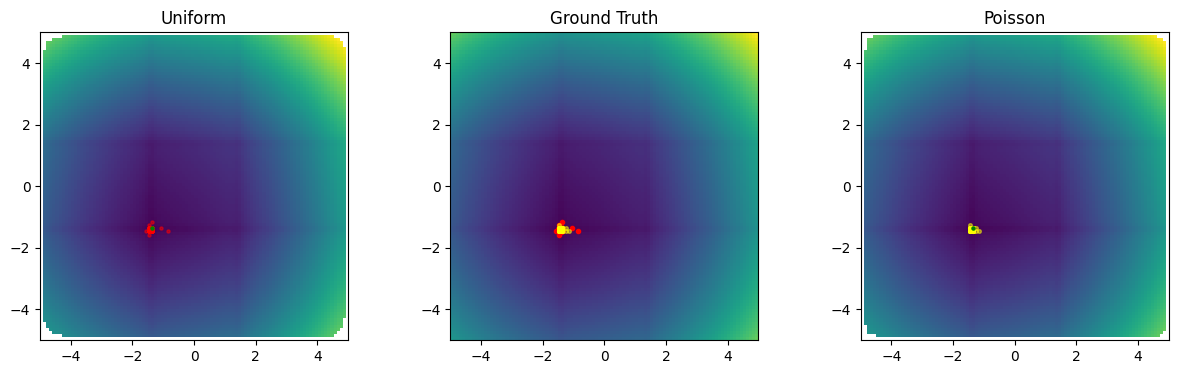

Disp U 0.10101010101010077 0.09639048705519844 4025.0
Disp H 0.10101010101010077 0.08240892356283584 4025.0
F1 0.9664874598034069 0.953265431837717 4025.0



In [18]:
plt.close()


for level in np.unique(xyls[0][1]): 
    
    collected_best_Hs = []
    collected_best_Us = []
    collected_best_GTs = []
    
    mean_H = 0
    mean_U = 0
    std_H = 0
    std_U = 0
    
    p_better = 0
    m_better = 0.0
    f1_u = []
    f1_h = []
    
    N_points = []
    
    for trial in range(len(xyls)):       
        # select level
        xy = xyls[trial][0]
        levels = xyls[trial][1]
        
        sel = levels <= level
        # select poisson points
        xy_poisson = xy[sel]
        
        N_points.append( len(xy_poisson) )
        # build uniform random points
        xy_uniform = np.random.uniform(lower, upper, (len(xy_poisson),2))

        # compute functions
        f_hiposa = []
        f_uniform = []
        for x_hiposa, x_uniform in zip(xy_poisson, xy_uniform):
            f_hiposa.append( f(x_hiposa) )
            f_uniform.append( f(x_uniform) )
        f_hiposa = np.array(f_hiposa)
        f_uniform = np.array(f_uniform)
        
        # interpolate
        grid_hiposa = griddata(xy_poisson, f_hiposa, (grid_x, grid_y), method='cubic')
        grid_uniform = griddata(xy_uniform, f_uniform, (grid_x, grid_y), method='cubic')

        min_H = np.unravel_index(np.nanargmin(grid_hiposa), (100,100) )
        min_U = np.unravel_index(np.nanargmin(grid_uniform), (100,100) )
        min_GT = np.unravel_index(np.nanargmin(f_gt), (100,100) )

        best_H = np.array([(grid_x[min_H],grid_y[min_H])])
        best_U = np.array([(grid_x[min_U],grid_y[min_U])])
        best_GT = np.array([(grid_x[min_GT],grid_y[min_GT])])
        
        #truncated_grid_uniform = grid_uniform[10:-10,10:-10]
        #truncated_f_gt = f_gt[10:-10,10:-10]
        #truncated_grid_hiposa = grid_hiposa[10:-10,10:-10]
        cc_H = compute_masked_similarity(grid_hiposa, f_gt, percentile=1, method='pearson')
        cc_U = compute_masked_similarity(grid_uniform, f_gt, percentile=1, method='pearson')        
        #print(cc_H['macro_f1'], cc_U['macro_f1'], cc_H['macro_f1'] > cc_U['macro_f1'])
        if cc_H['macro_f1'] > cc_U['macro_f1']:
            p_better += 1.0
        m_better += cc_H['macro_f1'] - cc_U['macro_f1']
        f1_u.append(cc_U['macro_f1'])
        f1_h.append(cc_H['macro_f1'])
        plt.imshow(f_gt)
        plt.colorbar()
        #visualize_mask_similarity(grid_hiposa, f_gt, percentile=1, method='f1', figsize=(12, 10))   
        #visualize_mask_similarity(grid_uniform, f_gt, percentile=1, method='f1', figsize=(12, 10))      
        if trial==20:    
            plt.close()        
            print("Single Instance")
            fig,axs = plt.subplots(1,3, figsize=(15,4))
            axs[0].imshow(grid_uniform, origin='lower', extent=(lower,upper,lower,upper))
            #axs[0].scatter(xy_uniform[:,1], xy_uniform[:,0], marker="+", c='black', s=8, alpha=0.25)
            axs[0].scatter(best_U[:,1], best_U[:,0],c="red", s=9)
            axs[0].scatter(best_GT[:,1], best_GT[:,0],c="green", s=5)

            axs[0].set_title("Uniform")

            axs[1].imshow(f_gt, origin='lower',extent=(lower,upper,lower,upper))        
            axs[1].scatter(best_U[:,1], best_U[:,0],c="red", s=5)
            axs[1].scatter(best_H[:,1], best_H[:,0],c="yellow", s=5)
            axs[1].scatter(best_GT[:,1], best_GT[:,0],c="green", s=5)        
            axs[1].set_title("Ground Truth")

            #axs[2].scatter(xy_poisson[:,1], xy_poisson[:,0], c='orange', s=4)
            axs[2].imshow(grid_hiposa, origin='lower', extent=(lower,upper,lower,upper))             
            #axs[2].scatter(xy_poisson[:,1], xy_poisson[:,0], marker="+", c='black', s=8, alpha=0.25) 
            axs[2].scatter(best_H[:,1], best_H[:,0],c="yellow", s=9)
            axs[2].scatter(best_GT[:,1], best_GT[:,0],c="green", s=5)     
            axs[2].set_title("Poisson")
            plt.show()
            
            print("Single Instance Zoom")
            fig,axs = plt.subplots(1,3, figsize=(15,4))
            axs[0].imshow(grid_uniform, origin='lower', extent=(lower,upper,lower,upper),vmin=2, vmax=7.0)
            axs[0].scatter(xy_uniform[:,1], xy_uniform[:,0], marker="+", c='black', s=8, alpha=0.25)
            axs[0].scatter(best_U[:,1], best_U[:,0],c="red", s=9)
            axs[0].scatter(best_GT[:,1], best_GT[:,0],c="green", s=5)
            axs[0].set_title("Uniform")
            axs[0].set_xlim(-2,0)
            axs[0].set_ylim(-2,0)
            
            

            axs[1].imshow(f_gt, origin='lower',extent=(lower,upper,lower,upper),vmin=2, vmax=7.0 )        
            axs[1].scatter(best_U[:,1], best_U[:,0],c="red", s=5)
            axs[1].scatter(best_H[:,1], best_H[:,0],c="yellow", s=5)
            axs[1].scatter(best_GT[:,1], best_GT[:,0],c="green", s=5)        
            axs[1].set_title("Ground Truth")
            axs[1].set_xlim(-2,0)
            axs[1].set_ylim(-2,0)
            
            #axs[2].scatter(xy_poisson[:,1], xy_poisson[:,0], c='orange', s=4)
            axs[2].imshow(grid_hiposa, origin='lower', extent=(lower,upper,lower,upper),vmin=2, vmax=7.0)             
            axs[2].scatter(xy_poisson[:,1], xy_poisson[:,0], marker="+", c='black', s=8, alpha=0.25) 
            axs[2].scatter(best_H[:,1], best_H[:,0],c="yellow", s=9)
            axs[2].scatter(best_GT[:,1], best_GT[:,0],c="green", s=5)     
            axs[2].set_title("Poisson")
            axs[2].set_xlim(-2,0)
            axs[2].set_ylim(-2,0)            
            plt.show()
            plt.close()

    
        mean_H += grid_hiposa
        mean_U += grid_uniform
        std_H += grid_hiposa**2
        std_U += grid_uniform**2            
            
        collected_best_GTs.append(best_GT)
        collected_best_Hs.append(best_H)        
        collected_best_Us.append(best_U)        
        
    collected_best_GTs = np.concatenate(collected_best_GTs)
    collected_best_Hs = np.concatenate(collected_best_Hs)
    collected_best_Us = np.concatenate(collected_best_Us)
    
    mean_H = mean_H / len(xyls)
    mean_U = mean_U / len(xyls)
    std_H = mean_H / len(xyls)
    std_U = mean_U / len(xyls)
    std_H = np.sqrt(np.abs(std_H - mean_H**2))
    std_U = np.sqrt(np.abs(std_U - mean_U**2))
    plt.close()
    if True:
            print("Agregate View")
            fig,axs = plt.subplots(1,3, figsize=(15,4))
            
            axs[0].imshow(mean_U, origin='lower', extent=(lower,upper,lower,upper))
            axs[0].scatter(collected_best_Us[:,1], collected_best_Us[:,0],c="red", s=5, alpha=0.50)
            axs[0].scatter(collected_best_GTs[0,1], collected_best_GTs[0,0],c="green", s=5)
            axs[0].set_title("Uniform")

            axs[1].imshow(f_gt, origin='lower',extent=(lower,upper,lower,upper))        
            axs[1].scatter(collected_best_Us[:,1], collected_best_Us[:,0],c="red", s=9)
            axs[1].scatter(collected_best_GTs[0,1], collected_best_GTs[0,0],c="green", s=9)   
            axs[1].scatter(collected_best_Hs[:,1], collected_best_Hs[:,0],c="yellow", s=7, alpha=0.50)

            axs[1].set_title("Ground Truth")

            axs[2].imshow(mean_H, origin='lower', extent=(lower,upper,lower,upper))
            #axs[0].scatter(xy_uniform[:,1], xy_uniform[:,0], c='red', s=4)
            axs[2].scatter(collected_best_Hs[:,1], collected_best_Hs[:,0],c="yellow", s=7, alpha=0.50)
            axs[2].scatter(collected_best_GTs[0,1], collected_best_GTs[0,0],c="green", s=5)
            axs[2].set_title("Poisson")
            plt.show()    
      
    d_U = collected_best_Us - collected_best_GTs
    d_H = collected_best_Hs - collected_best_GTs
    d_U = np.sum(d_U**2, axis=-1)**0.5
    d_H = np.sum(d_H**2, axis=-1)**0.5
    
    
    print( "Disp U", np.median(d_U), np.mean(d_U), np.median(np.array(N_points)) )
    print( "Disp H", np.median(d_H), np.mean(d_H), np.median(np.array(N_points)))
    print( "F1", np.mean(f1_h), np.mean(f1_u), np.median(np.array(N_points)))
    print()
    print(80*"=")